## U-Net：用于生物医学图像分割的卷积网络
<!-- U-Net: Convolutional Networks for Biomedical Image Segmentation -->

## 一、引言

1. 背景：卷积网络在视觉任务中取得突破，但生物医学分割需要"定位+少量样本"，现有方法无法满足；
2. 现有方法的缺陷：滑动窗口法速度慢、定位与上下文难以兼顾、数据增强有限；
3. 核心基础：基于全卷积网络（FCN）改进，核心是"上采样+特征融合"；
4. 关键创新：
   1. U形对成结构（收缩+扩展路径）；
   2. 重叠瓦片策略（解决大型图像分割与GPU内存限制）；
   3. 弹性变形数据增强（少量样本下学习变形不变性）；
   4. 加权损失函数（分离相邻同类边界）。

## 二、网络结构

1. 整体结构：左右对成U形结构，分为收缩路径（下采样，捕捉上下文）和扩展路径（上采样，精确定位）；
2. 收缩路径流程：3x3卷积(无填充) -> ReLU -> 3x3卷积(无填充) -> ReLU -> 2x2最大池化(步长2)；每步通道数翻倍
3. 扩展路径流程：上采样 -> 2x2上卷积(通道数减半) -> 与收缩路径特征图拼接（需剪裁） -> 3x3卷积 -> ReLU -> 3x3卷积 -> ReLU；
4. 关键细节：无全连接层，共23个卷积层；输入瓦片大小需要满足偶数尺寸，以适配无缝拼接。

<div style="background-color:white; padding:10px; border-radius:5px; width:80%; margin:auto; text-align:center;">
    <image src="./assets/u-net-illustration-correct-scale2.png" />
    <span style="font-size:12px; color:gray; display:block; ">图1 U-Net架构示意图(图片最小尺寸32x32)</span>
</div>

[完整实现代码](./my_unet_9517/unet/unet_parts.py)

__双卷积块__:
```py
class DoubleConv(nn.Module):
    """ 输入: [B, 64, H, W] -> [B, 128, H, W] -> [B, 128, H, W] """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
```

__收缩路径__:
```py
class Down(nn.Module):  # 红色箭头 + 2个蓝色箭头
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),  # 无参数，2x2最大池化，步长2，尺寸减半
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
```

__扩展路径__:
```py
class Up(nn.Module):
    """上采样和双卷积"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:  # NT: bilinear通过周围4个像素的加权平均值计算新像素值，align_corners保持角点对齐
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:  # NT: 转置卷积(反卷积)，能更好保留细节，但参数更多且可能过拟合 <- 论文中使用这个
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2): # HL: 这里是让后面的x1(padding)适配前面特征图x2的尺寸（论文中则相反(crop)），
        # HL: 这样做的好处是保留了更多像素点信息，且最终输出的特征图尺寸和最初输入一致
        x1 = self.up(x1) # 上采样 x1 -> [B, 512, 104, 104]
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # 拼接 => [B, 1024, 136, 136]
        return self.conv(x)  # 双卷积 => [B, 512, 136, 136]
```

<div style="background-color:white; padding:10px; border-radius:5px; width:80%; margin:auto; text-align:center;">
    <image src="./assets/overlap-tile.png" />
    <span style="font-size:12px; color:gray; display:block; ">图2 重叠瓦片策略用于无缝分割任意大型图像</span>
</div>

原始图像尺寸：H=251, W=371, C=3
拓展尺寸：上下各26像素，左右各38像素
拓展后图像尺寸：H=303, W=447


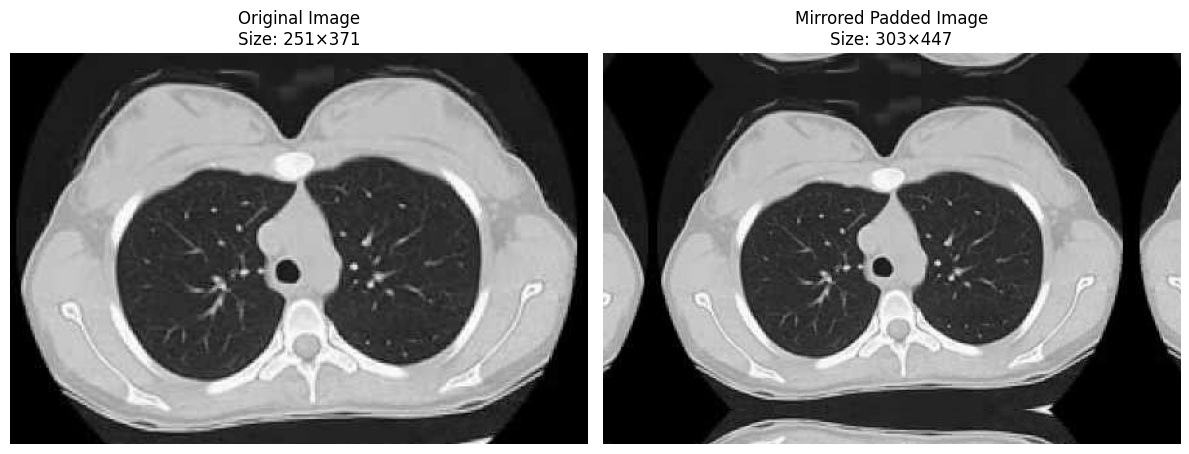

拓展后的图像已保存！


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------- 1. 读取图像 --------------------------
img_path = "./assets/siim-medical-images_10.png"
# 读取图像并转为numpy数组 (H, W, C)
img = Image.open(img_path).convert("RGB")  # 确保RGB格式
img_np = np.array(img)
H, W, C = img_np.shape
print(f"原始图像尺寸：H={H}, W={W}, C={C}")

# -------------------------- 2. 计算10%拓展尺寸 --------------------------
# 计算上下/左右需要拓展的像素数（10%），向上取整避免小数
pad_h = int(np.ceil(H * 0.1))
pad_w = int(np.ceil(W * 0.1))
print(f"拓展尺寸：上下各{pad_h}像素，左右各{pad_w}像素")

# -------------------------- 3. 镜像拓展边缘 --------------------------
# numpy.pad参数说明：
# pad_width=( (上填充, 下填充), (左填充, 右填充), (通道填充, 通道填充) )
# mode='reflect'：镜像填充（无重复边界像素，符合U-Net论文策略）
img_padded = np.pad(
    img_np,
    pad_width=((pad_h, pad_h), (pad_w, pad_w), (0, 0)),  # 通道不填充
    mode='reflect'
)
print(f"拓展后图像尺寸：H={img_padded.shape[0]}, W={img_padded.shape[1]}")

# -------------------------- 4. 可视化对比 --------------------------
plt.figure(figsize=(12, 6))

# 原始图像
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f"Original Image\nSize: {H}×{W}")
plt.axis('off')

# 拓展后图像
plt.subplot(1, 2, 2)
plt.imshow(img_padded)
plt.title(f"Mirrored Padded Image\nSize: {img_padded.shape[0]}×{img_padded.shape[1]}")
plt.axis('off')

plt.tight_layout()
plt.show()

# -------------------------- 5. 可选：保存拓展后的图像 --------------------------
img_padded_pil = Image.fromarray(img_padded)
img_padded_pil.save("./assets/siim-medical-images_10_padded.png")
print("拓展后的图像已保存！")

## 三、训练

1. 训练配置: 基于Caffe的随机梯度下降，批次大小=1（大输入瓦片优先），动量=0.99
2. 损失函数：逐像素soft-max+交叉熵，引入权重图w(x)，核心作用：a.平衡类别频率；b.强化相邻细胞分隔边界的学习；
3. 权重初始化：从标准差为$\sqrt{2/N}$的高斯分布采样（N为神经元输入节点数），避免过度激活或急或不足；
4. 数据增强（核心）：
   1. a. 随机弹性变形（3x3网络+高斯位移+双三次插值）；
   2. b.收缩路径末端dropout；
   3. c. 覆盖平移、旋转、灰度变化鲁棒性需求。

- soft-max定义为:
$$\begin{aligned}
p_k(x) &= \frac{\exp(a_k(x))}{\sum_{k'=1}^K \exp(a_{k'}(x))} \\
\end{aligned}$$
- $K$为类别数，$a_k(x)$为像素$x$对应类别$k$的激活值，$p_k(x)$为soft-max概率。

$$\begin{aligned}
E &= \sum_{x \in \Omega} w(x) \log (p_{\ell(x)}(x)) \\
w(x) &= w_c(x) + w_0 \cdot \exp\left(-\frac{(d_1(x) + d_2(x))^2}{2\sigma^2}\right) \\
\end{aligned}$$

- $x \in \Omega$为图像像素集合，$\ell(x)$为像素$x$的真实类别标签，$w_c(x)$为权重映射，$d_1(x)$和$d_2(x)$分别为像素$x$到最近和次近细胞边界的距离，$w_0$和$\sigma$为超参数（论文中取$w_0=10$，$\sigma \approx 5$个像素）。